In [1]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import uproot
import mplhep as hep
import pandas as pd
hep.style.use("CMS")

In [2]:
run = 841
data = uproot.concatenate([f'/nfs/disk1/eos/eos-processed-data-jan25/rat_processed_data/run{run}/*.root:output'])
mc = uproot.open('/nfs/disk1/eos/mc-production-bu/90Y_z-500_theta180_phi0.0_run834.root')['output'].arrays()

meta = uproot.open('/nfs/disk1/eos/mc-production-bu/90Y_z-500_theta180_phi0.0_run834.root')['meta'].arrays()
meta = ak.to_dataframe(meta)

pmt_position = meta[['pmtX', 'pmtY', 'pmtZ']].to_numpy()
pmt_type = meta['pmtType'].to_numpy()
pmt_direction = meta[['pmtU', 'pmtV', 'pmtW']].to_numpy()
source_position = meta[['source_pos_x', 'source_pos_y', 'source_pos_z']].to_numpy()[0]
time_of_flight = np.linalg.norm(pmt_position - source_position[np.newaxis, :], axis=1)
time_of_flight /= (299.792 / 1.333)
pmtinfo = pd.DataFrame({
    'position': [p for p in pmt_position],
    'direction': [d for d in pmt_direction],
    'type': pmt_type,
    'lcn': meta['pmtChannel'].to_numpy()
})

dirsrc_info = pd.read_csv('DIRSRC_INFO.csv', sep='\s+')
dirsrc_info = dirsrc_info[dirsrc_info['run'] == 841].iloc[0]

In [3]:
def convert_ntuple_to_df(ntuple):
    ev = {
        'evid': ntuple.evid.to_numpy(),
        'mcpdg': ntuple.mcpdg.to_numpy(),
        'mcpos': np.array([ntuple.mcx, ntuple.mcy, ntuple.mcz]).T,
        'mcdir': np.array([ntuple.mcu, ntuple.mcv, ntuple.mcw]).T,
        'mct': ntuple.mct.to_numpy(),
        'mcke': ntuple.mcke.to_numpy(),
        'triggerTime': ntuple.triggerTime.to_numpy(),
        'nhits': ntuple.digitNhits.to_numpy(),
    }
    ev['mcpos'] = [row for row in ev['mcpos']]
    ev['mcdir'] = [row for row in ev['mcdir']]
    hits = {
        'evid': ak.flatten(ak.broadcast_arrays(ntuple.digitTime, ntuple.evid)[1]).to_numpy(),
        'digitPMTID': ak.flatten(ntuple.digitPMTID).to_numpy(),
        'digitTime': ak.flatten(ntuple.digitTime).to_numpy(),
        'digitCharge': ak.flatten(ntuple.digitCharge).to_numpy(),
        'digitNCrossings': ak.flatten(ntuple.digitNCrossings).to_numpy(),
        'digitPeak': ak.flatten(ntuple.digitPeak).to_numpy(),
        'digitLocalTriggerTime': ak.flatten(ntuple.digitLocalTriggerTime).to_numpy(),
        'fit_pmtid_Lognormal': ak.flatten(ntuple.fit_pmtid_Lognormal).to_numpy(),
        'fit_time_Lognormal': ak.flatten(ntuple.fit_time_Lognormal).to_numpy(),
        'fit_charge_Lognormal': ak.flatten(ntuple.fit_charge_Lognormal).to_numpy(),
        'fit_pmtid_Gaussian': ak.flatten(ntuple.fit_pmtid_Gaussian).to_numpy(),
        'fit_time_Gaussian': ak.flatten(ntuple.fit_time_Gaussian).to_numpy(),
        'fit_charge_Gaussian': ak.flatten(ntuple.fit_charge_Gaussian).to_numpy(),
           }
    return pd.DataFrame(ev), pd.DataFrame(hits)


data_ev, data_hits = convert_ntuple_to_df(data)
mc_ev, mc_hits = convert_ntuple_to_df(mc)

from collections import defaultdict
# dichoicon_delays = defaultdict(int)
dichroicon_delays = {
    112: 124.1260,
    113: 49.1310,
    115: 124,  # not true
    116: 124.4921,
    118: 122.8448,
    119: 122.9837,
    120: 122,  # not true
    121: 124.5845,
    123: 120.1319,
}
dichroicon_delays = defaultdict(int, dichroicon_delays)


data_hits = pd.merge(data_hits, pmtinfo[['lcn', 'type']], left_on='digitPMTID', right_index=True)
data_hits['fit_time_Lognormal'] -= data_hits['lcn'].map(dichroicon_delays)


# Cuts

[]

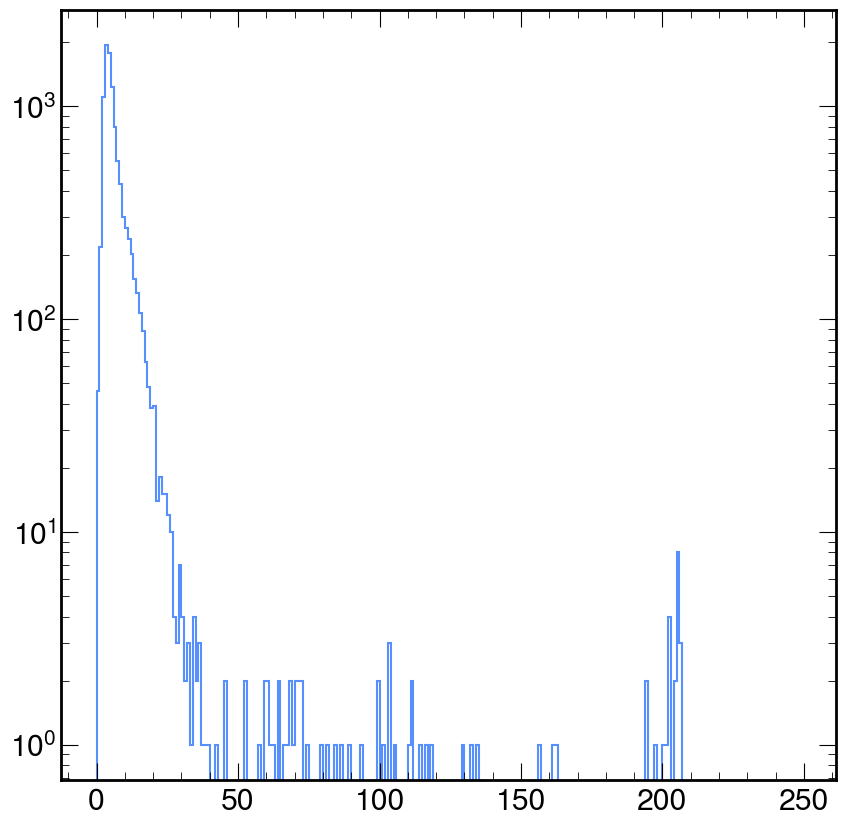

In [4]:
nhits = np.histogram(data_ev['nhits'], bins=np.arange(250))
hep.histplot(nhits)
plt.semilogy()

In [5]:
# Calculate time residual
data_hits['tresid'] = data_hits.fit_time_Lognormal - time_of_flight[data_hits.fit_pmtid_Lognormal]
mc_hits['tresid'] = mc_hits.fit_time_Lognormal - time_of_flight[mc_hits.fit_pmtid_Lognormal]
data_ev = pd.merge(data_ev, data_hits.groupby('evid')['tresid'].mean().rename('mean_tresid'), on='evid')
data_ev = pd.merge(data_ev, data_hits.groupby('evid')['tresid'].std().rename('std_tresid'), on='evid')
mc_ev = pd.merge(mc_ev, mc_hits.groupby('evid')['tresid'].mean().rename('mean_tresid'), on='evid')
mc_ev = pd.merge(mc_ev, mc_hits.groupby('evid')['tresid'].std().rename('std_tresid'), on='evid')

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7318a919fa40>, errorbar=None, legend_artist=None)]

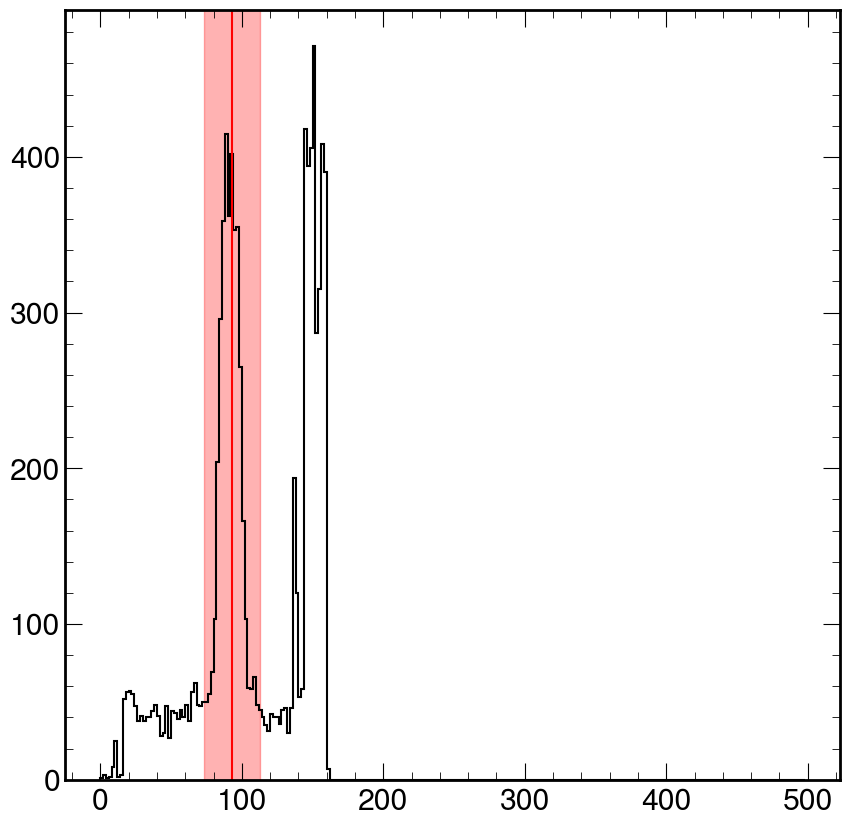

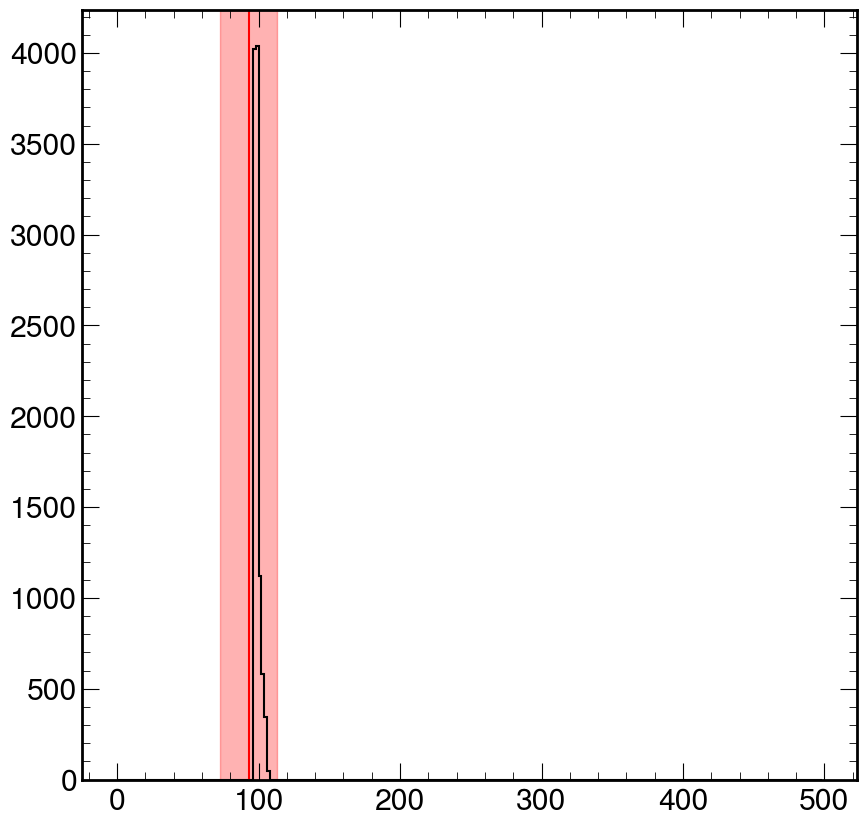

In [6]:
h = np.histogram(data_ev.triggerTime, bins=np.arange(0, 500, 2))
plt.axvline(dirsrc_info.trigger_time, color='r')
plt.axvspan(dirsrc_info.trigger_time - 20, dirsrc_info.trigger_time + 20, color='r', alpha=0.3)
# plt.semilogy()
hep.histplot(h, color='k')

plt.figure()
h = np.histogram(mc_ev.triggerTime + dirsrc_info.trigger_time, bins=np.arange(0, 500, 2))
plt.axvline(dirsrc_info.trigger_time, color='r')
plt.axvspan(dirsrc_info.trigger_time - 20, dirsrc_info.trigger_time + 20, color='r', alpha=0.3)
# plt.semilogy()
hep.histplot(h, color='k')

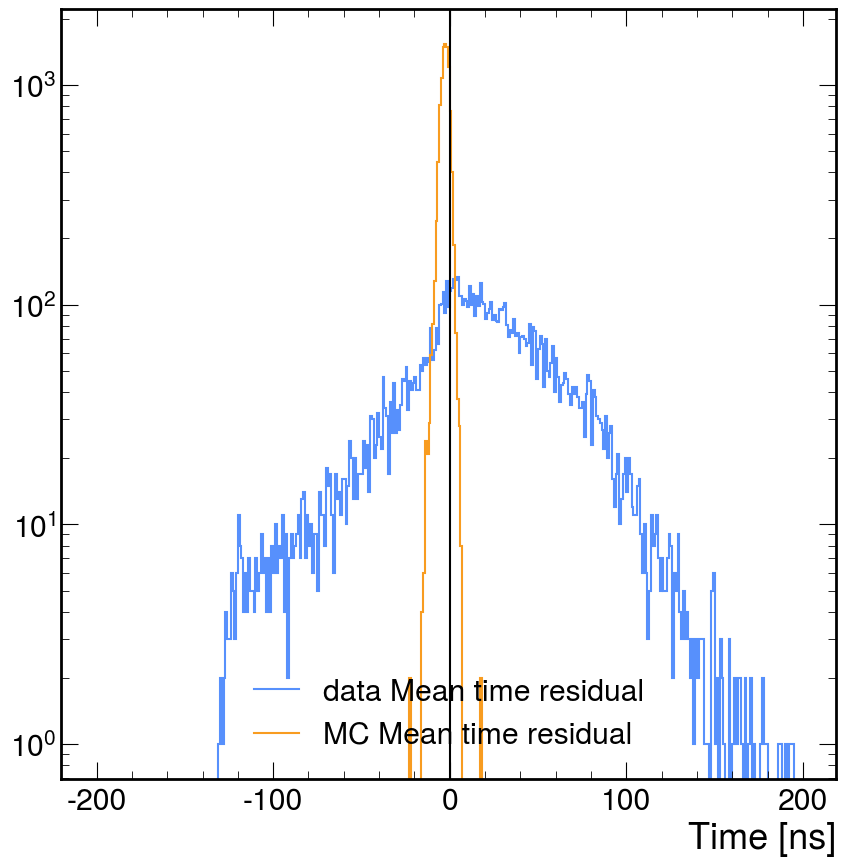

In [19]:
hep.histplot(np.histogram(data_ev['mean_tresid'], bins=np.arange(-200, 200)), label='data Mean time residual')
hep.histplot(np.histogram(mc_ev['mean_tresid'], bins=np.arange(-25, 100)), label='MC Mean time residual')
# hep.histplot(np.histogram(mc_hits['fit_time_Lognormal'], bins=np.arange(-25, 100)), label='Lognormal')
# hep.histplot(np.histogram(ak.flatten(mc['mcPEFrontEndTime']).to_numpy(), bins=np.arange(-25, 100)), label='mcPEFrontEndTime')
plt.xlabel("Time [ns]")
plt.legend()
plt.semilogy()
plt.axvline(0, color='k')
plt.show()

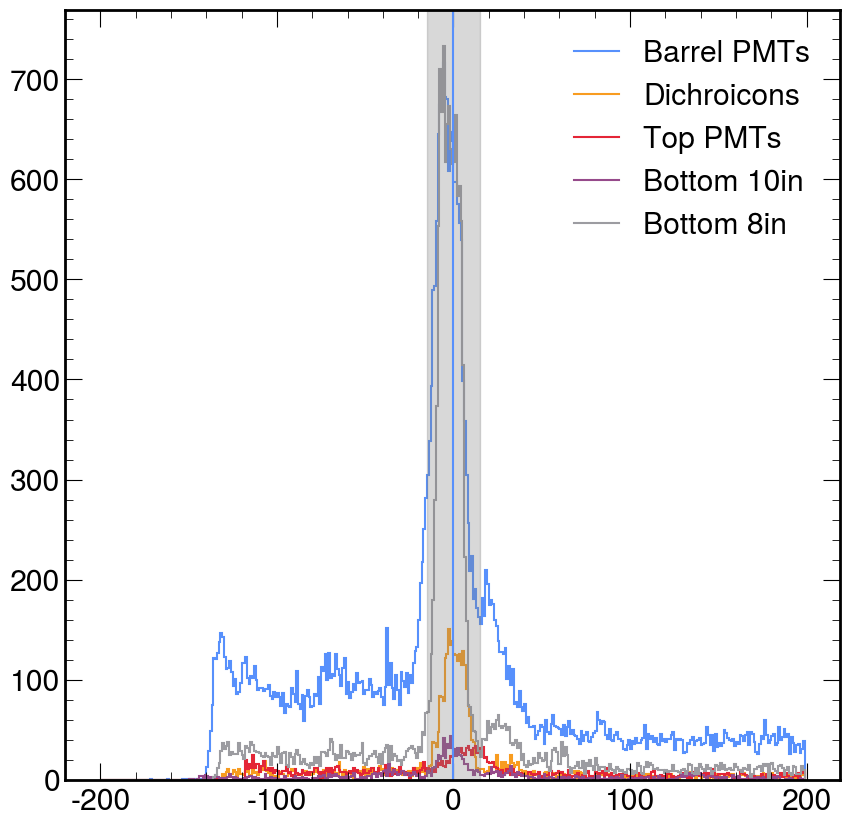

In [21]:
hep.histplot(np.histogram(data_hits[data_hits['type'] == 0]['tresid'] - dirsrc_info.event_time, bins=np.arange(-200, 200)), label='Barrel PMTs')
hep.histplot(np.histogram(data_hits[data_hits['type'] == 1]['tresid'] - dirsrc_info.event_time, bins=np.arange(-200, 200)), label='Dichroicons')
hep.histplot(np.histogram(data_hits[data_hits['type'] == 2]['tresid'] - dirsrc_info.event_time, bins=np.arange(-200, 200)), label='Top PMTs')
hep.histplot(np.histogram(data_hits[data_hits['type'] == 3]['tresid'] - dirsrc_info.event_time, bins=np.arange(-200, 200)), label='Bottom 10in')
hep.histplot(np.histogram(data_hits[data_hits['type'] == 4]['tresid'] - dirsrc_info.event_time, bins=np.arange(-200, 200)), label='Bottom 8in')
plt.legend()

plt.axvline(0)
plt.axvspan(-15, +15, color='grey', alpha=0.3)

In [27]:
def apply_cuts(ev, hits):
    mask = (ev.nhits < 50) & (ev.nhits > 5)
    mask &= (np.abs(ev['triggerTime'] - dirsrc_info.trigger_time) < 20)
    cut_ev = ev[mask].reset_index()
    cut_hits = hits[hits['evid'].isin(cut_ev['evid'])].reset_index()
    cut_hits = cut_hits[np.abs(cut_hits['tresid'] - dirsrc_info.event_time) < 15]
    return cut_ev, cut_hits

data_ev_cleaned, data_hits_cleaned = apply_cuts(data_ev, data_hits)
# data_hits_cleaned = pd.merge(data_hits_cleaned, pmtinfo, left_on='digitPMTID', right_index=True)

In [30]:
data_hits_cleaned[data_hits_cleaned.type==1]

,index,evid,digitPMTID,digitTime,digitCharge,digitNCrossings,digitPeak,digitLocalTriggerTime,fit_pmtid_Lognormal,fit_time_Lognormal,fit_charge_Lognormal,fit_pmtid_Gaussian,fit_time_Gaussian,fit_charge_Gaussian,lcn,type,tresid
3,23,4499,24,135.224089,1.196289,1,-12.390137,276.323776,24,14.765805,1.446022,24,137.674403,1.436755,119,1,11.616149
27,86,4511,11,126.040444,1.132812,1,-11.877441,276.316607,11,4.596492,1.153153,11,128.525534,1.119487,115,1,1.020237
30,89,4511,19,128.384478,1.987305,1,-15.625000,276.316607,19,8.111609,1.443536,19,130.885877,1.400328,118,1,4.595266
32,91,4511,28,130.654200,2.026367,1,-20.605469,276.316607,28,8.538680,1.808594,28,133.075943,1.779772,121,1,4.986935
47,212,4531,24,126.873707,3.784180,1,-27.490234,276.318974,24,6.606464,2.772942,24,129.513818,2.722554,119,1,3.456807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24666,66149,9347,1,133.200374,2.236328,1,-19.421387,276.317587,1,11.438992,1.881461,1,135.502763,1.889678,112,1,7.124507
24682,66168,9349,19,135.986667,1.318359,1,-10.742188,276.330020,19,16.171821,0.994826,19,138.933691,1.001550,118,1,12.655478
24683,66169,9349,24,135.954926,2.045898,1,-16.430664,276.330020,24,15.819492,1.749684,24,138.730320,1.731887,119,1,12.669835
24692,66254,9366,24,126.743405,2.353516,1,-17.919922,276.299277,24,6.604851,1.894732,24,129.509231,1.876204,119,1,3.455195


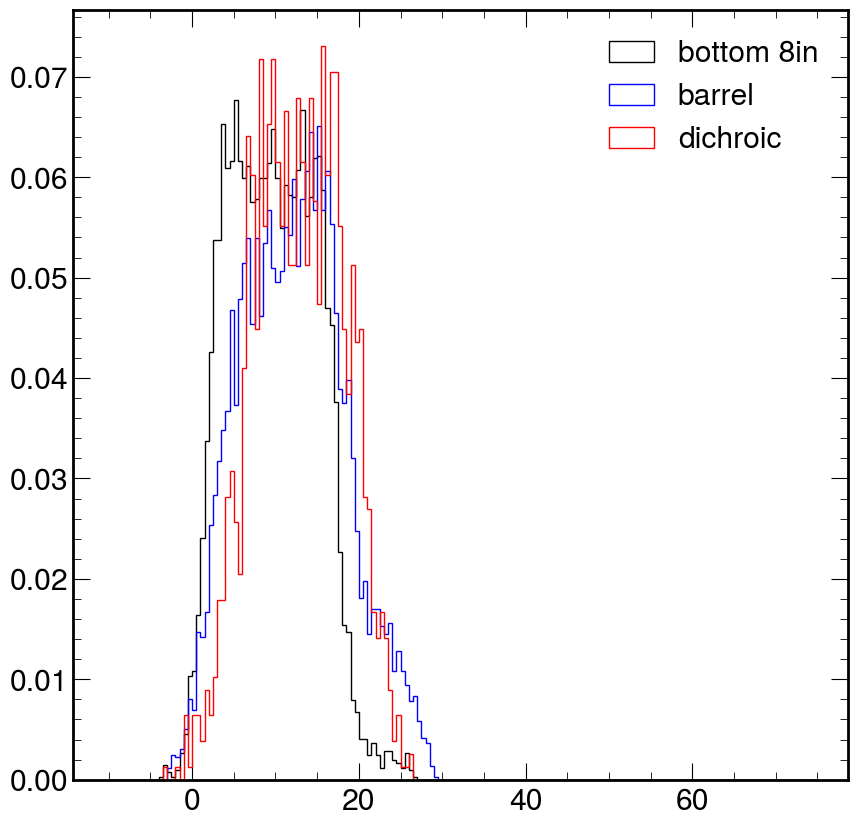

In [32]:
binning = np.arange(-10, 75, 0.5)
bottom_8in_hits = data_hits_cleaned.query('type == 4')
plt.hist(bottom_8in_hits.fit_time_Lognormal, bins=binning, histtype='step', color='k', linewidth=1, density=True, label='bottom 8in')
barrel_hits = data_hits_cleaned.query('type == 0')
plt.hist(barrel_hits.fit_time_Lognormal, bins=binning, histtype='step', color='b', linewidth=1, density=True, label='barrel')
dichroicon_hits = data_hits_cleaned.query('type == 1').reset_index()
plt.hist(dichroicon_hits.fit_time_Lognormal, bins=binning, histtype='step', color='r', linewidth=1, density=True, label='dichroic')
# plt.axvline(dirsrc_info.trigger_time, color='k')

plt.legend()
plt.show()

Text(0, 1, 'Normalized Occupancy')

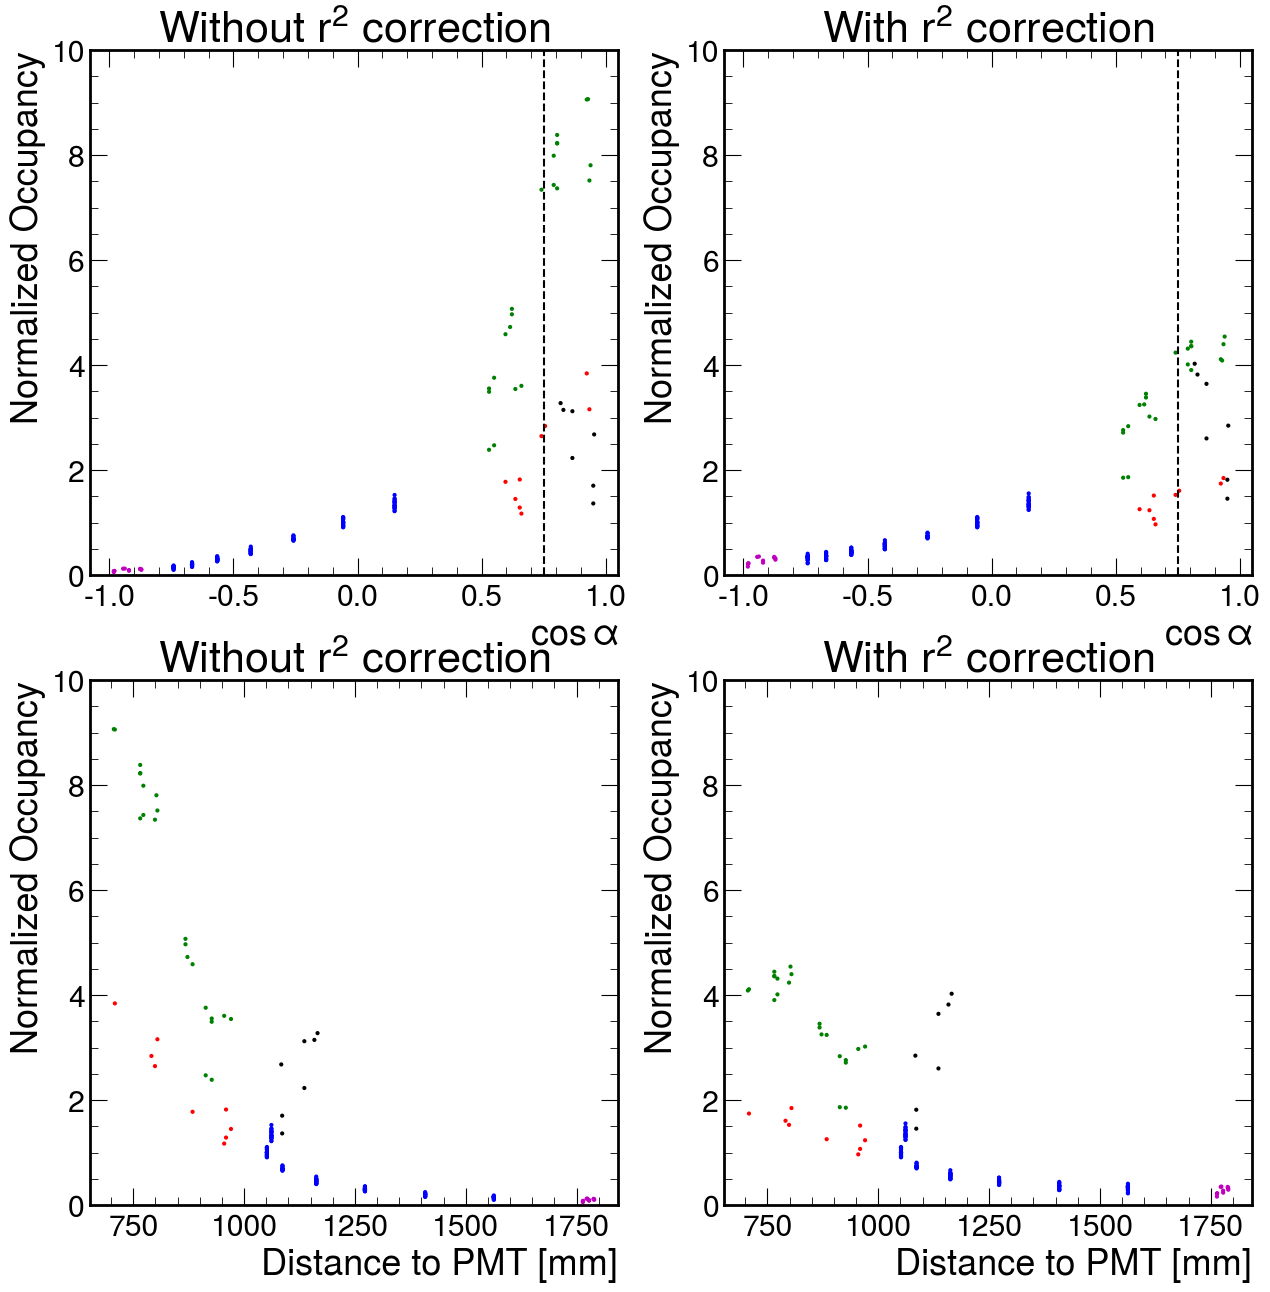

In [36]:
barrel_pmtpos = np.stack(pmtinfo[pmtinfo.type==0].position)
pmtpos = np.stack((pmtinfo.position))
barrel_zs = np.unique(pmtpos[:, 2])
closest_z = barrel_zs[np.argmin(np.abs(source_position[2] - barrel_zs))]
calpmt_ids = pmtinfo.index[pmtpos[:, 2]==closest_z]

cal_hits = mc_hits[mc_hits.digitPMTID.isin(calpmt_ids)].reset_index()
cal_mean_occupancy = np.mean(cal_hits.groupby('digitPMTID').size())


pmt_dr = pmtpos - source_position
pmt_dist = np.linalg.norm(pmt_dr, axis=1)
cal_mean_dist = np.mean(pmt_dist[calpmt_ids])

pmt_dr /= np.linalg.norm(pmt_dr, axis=1)[:, np.newaxis]
source_direction = np.array([0, 0, -1])
pmt_cosalpha = np.einsum('ij,j->i', pmt_dr, source_direction)
mc_occupancies = mc_hits.groupby('digitPMTID').size()
mc_occupancies /= cal_mean_occupancy
mc_occupancies_dist_corrected = mc_occupancies * (pmt_dist[mc_occupancies.index] / cal_mean_dist)**2
color_index = {0: 'b',  # barrel PMTs
               1: 'r',  # Dichroicons
               2: 'm',  # Top PMTs
               3: 'k',  # 10inch PMTs
               4: 'g',  # bottom 8in PMTs
              }
mc_colors = [color_index[t] for t in pmtinfo.iloc[mc_occupancies.index].type]
plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.scatter(pmt_cosalpha[mc_occupancies.index], mc_occupancies, s=4, c=mc_colors)
plt.title(r'Without $r^2$ correction')
plt.xlabel(r"$\cos\alpha$")
plt.ylabel(r"Normalized Occupancy")
plt.ylim(0, 10)
plt.axvline(0.75, color='k', linestyle='--')


plt.subplot(222)
plt.scatter(pmt_cosalpha[mc_occupancies.index], mc_occupancies_dist_corrected, s=4, c=mc_colors)
plt.title(r'With $r^2$ correction')
plt.xlabel(r"$\cos\alpha$")
plt.ylabel(r"Normalized Occupancy")
plt.ylim(0, 10)
plt.axvline(0.75, color='k', linestyle='--')

plt.subplot(223)
plt.scatter(pmt_dist[mc_occupancies.index], mc_occupancies*(pmt_dist[mc_occupancies.index])**0, s=4, c=mc_colors)
plt.ylim(0, 10)
plt.title(r'Without $r^2$ correction')
plt.xlabel(r"Distance to PMT [mm]")
plt.ylabel(r"Normalized Occupancy")

plt.subplot(224)
plt.scatter(pmt_dist[mc_occupancies.index], mc_occupancies_dist_corrected, s=4, c=mc_colors)
plt.ylim(0, 10)
plt.title(r'With $r^2$ correction')
plt.xlabel(r"Distance to PMT [mm]")
plt.ylabel(r"Normalized Occupancy")


Text(0, 1, 'Normalized Occupancy')

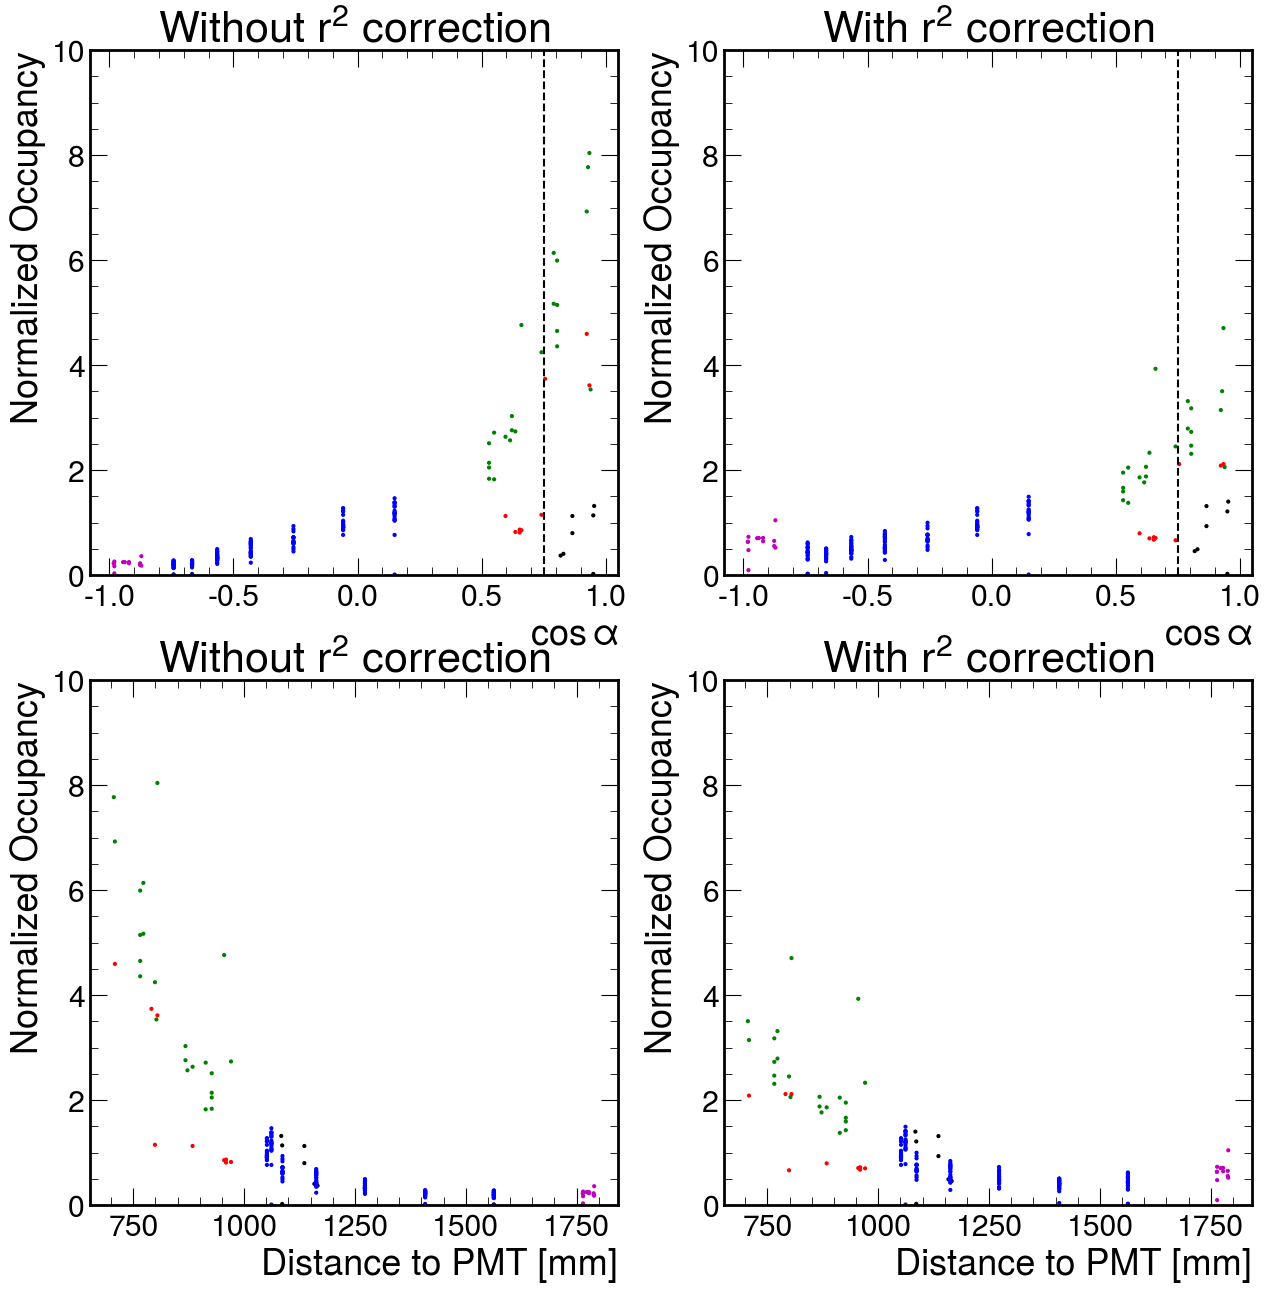

In [41]:
barrel_pmtpos = np.stack(pmtinfo[pmtinfo.type==0].position)
pmtpos = np.stack((pmtinfo.position))
barrel_zs = np.unique(pmtpos[:, 2])
closest_z = barrel_zs[np.argmin(np.abs(source_position[2] - barrel_zs))]
calpmt_ids = pmtinfo.index[pmtpos[:, 2]==closest_z]

cal_hits = data_hits_cleaned[data_hits_cleaned.digitPMTID.isin(calpmt_ids)].reset_index()
cal_mean_occupancy = np.mean(cal_hits.groupby('digitPMTID').size())


pmt_dr = pmtpos - source_position
pmt_dist = np.linalg.norm(pmt_dr, axis=1)
cal_mean_dist = np.mean(pmt_dist[calpmt_ids])

pmt_dr /= np.linalg.norm(pmt_dr, axis=1)[:, np.newaxis]
source_direction = np.array([0, 0, -1])
pmt_cosalpha = np.einsum('ij,j->i', pmt_dr, source_direction)
data_occupancies = data_hits_cleaned.groupby('digitPMTID').size()
data_occupancies /= cal_mean_occupancy
data_occupancies_dist_corrected = data_occupancies * (pmt_dist[data_occupancies.index] / cal_mean_dist)**2
color_index = {0: 'b',  # barrel PMTs
               1: 'r',  # Dichroicons
               2: 'm',  # Top PMTs
               3: 'k',  # 10inch PMTs
               4: 'g',  # bottom 8in PMTs
              }
data_colors = [color_index[t] for t in pmtinfo.iloc[data_occupancies.index].type]
plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.scatter(pmt_cosalpha[data_occupancies.index], data_occupancies, s=4, c=data_colors)
plt.title(r'Without $r^2$ correction')
plt.xlabel(r"$\cos\alpha$")
plt.ylabel(r"Normalized Occupancy")
plt.ylim(0, 10)
plt.axvline(0.75, color='k', linestyle='--')


plt.subplot(222)
plt.scatter(pmt_cosalpha[data_occupancies.index], data_occupancies_dist_corrected, s=4, c=data_colors)
plt.title(r'With $r^2$ correction')
plt.xlabel(r"$\cos\alpha$")
plt.ylabel(r"Normalized Occupancy")
plt.ylim(0, 10)
plt.axvline(0.75, color='k', linestyle='--')

plt.subplot(223)
plt.scatter(pmt_dist[data_occupancies.index], data_occupancies*(pmt_dist[data_occupancies.index])**0, s=4, c=data_colors)
plt.ylim(0, 10)
plt.title(r'Without $r^2$ correction')
plt.xlabel(r"Distance to PMT [mm]")
plt.ylabel(r"Normalized Occupancy")

plt.subplot(224)
plt.scatter(pmt_dist[data_occupancies.index], data_occupancies_dist_corrected, s=4, c=data_colors)
plt.ylim(0, 10)
plt.title(r'With $r^2$ correction')
plt.xlabel(r"Distance to PMT [mm]")
plt.ylabel(r"Normalized Occupancy")


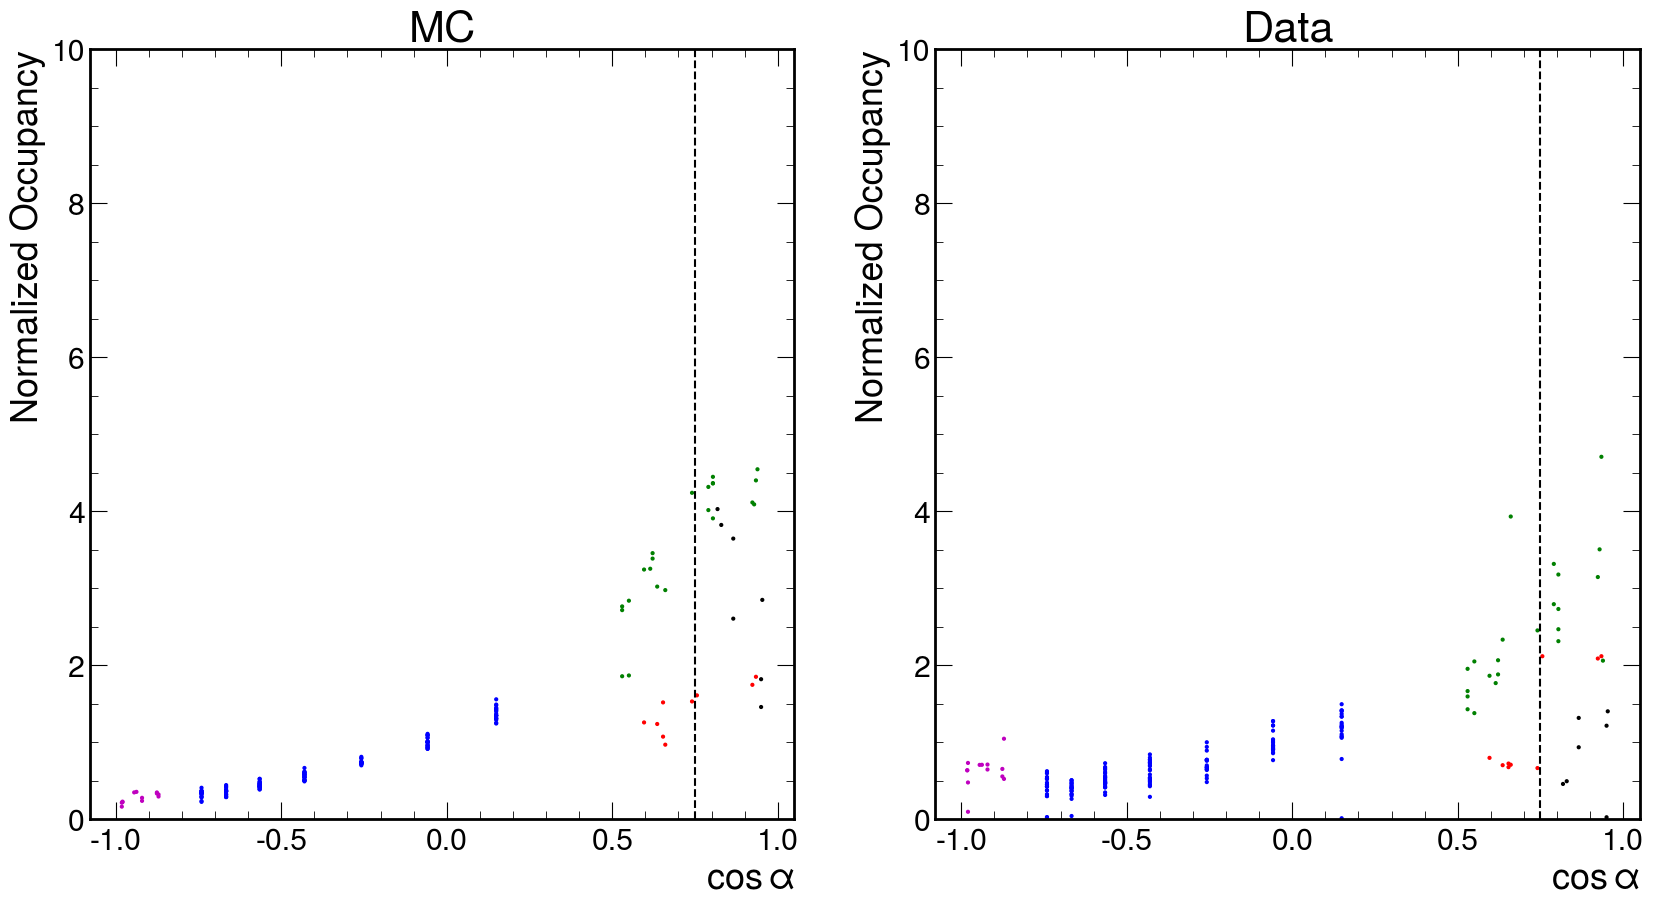

In [66]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(pmt_cosalpha[mc_occupancies.index], mc_occupancies_dist_corrected, s=4, c=mc_colors)
plt.xlabel(r"$\cos\alpha$")
plt.ylabel(r"Normalized Occupancy")
plt.title("MC")
plt.ylim(0, 10)
plt.axvline(0.75, color='k', linestyle='--')
plt.subplot(122)
plt.scatter(pmt_cosalpha[data_occupancies.index], data_occupancies_dist_corrected, s=4, c=data_colors)
plt.xlabel(r"$\cos\alpha$")
plt.ylabel(r"Normalized Occupancy")
plt.title("Data")
plt.ylim(0, 10)
plt.axvline(0.75, color='k', linestyle='--')

(0.0, 8.0)

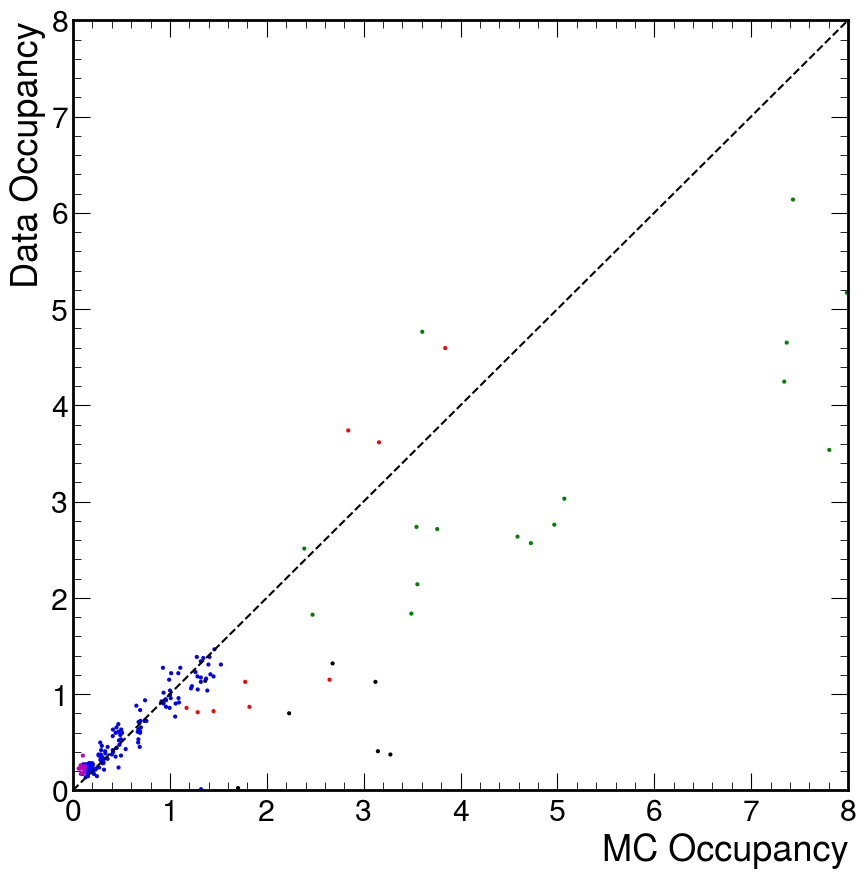

In [65]:
data_vs_mc = pd.concat([data_occupancies.rename('data'), mc_occupancies.rename('mc')], axis=1)
data_vs_mc['color'] = [color_index[t] for t in pmtinfo.iloc[data_vs_mc.index].type]
plt.scatter(data_vs_mc['mc'], data_vs_mc['data'], c=data_vs_mc.color, s=4)
plt.xlabel('MC Occupancy')
plt.ylabel("Data Occupancy")
plt.plot([0, 10], [0, 10], 'k--')
plt.xlim(0, 8)
plt.ylim(0, 8)